IMPORTING LIBRARIES

In [2]:
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt
import numpy as np

CODE TO CHECK IF THE GPU IS DETECTED

In [3]:
import torch
torch.cuda.empty_cache()

assert torch.cuda.is_available()

#Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: NVIDIA A100-SXM-80GB MIG 2g.20gb, n_gpu: 1


LOAD THE DATASET

In [4]:
#how to train the model without a test set.
momentum = load_dataset('json', data_files='MPM.json')
#momentum = load_dataset('json', data_files='MPM_conditioned.json', split = 'train')
#momentum = momentum.train_test_split(test_size=0.2)
flattened_mpm = momentum.flatten()
example = flattened_mpm["train"][0]
example

Found cached dataset json (/home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)
100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


{'URL': 'https://accure.ai/docs/momentum-user-guide/getting-started-with-momentum/1-getting-started-with-momentum/',
 'Product_Title': 'Momentum',
 'Section_Title': 'Getting Started with Momentum',
 'Section_Num': 1,
 'Article_Title': 'Accessing Momentum',
 'Article_Num': 1,
 'Article_Body': 'Momentum is a web-based system that is accessible via a web browser. To launch Momentum, point your browser address to: \nhttp://<public-ip-or-domain>:8800/mv-admin \nIf you installed Momentum from AWS marketplace, the default port to access Momentum is 8800. \nThe above URL will launch the login page.'}

TOKENIZE THE DATA AND ADD THE PAD TOKENS TO THE DATA

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

PREPROCESS THE DATA WITH THE REQUIRED FIELDS

In [6]:
def preprocess_function(examples):
    articles = [" ".join(article.split()) for article in examples["Article_Body"]]
    return tokenizer(articles, truncation=True)

MAP THE TOKENIZED DATA

In [7]:
tokenized_mpm = flattened_mpm.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=momentum["train"].column_names,
)

Loading cached processed dataset at /home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e/cache-6d5262b5f5ab4d71_*_of_00004.arrow


ENCODE THE DATA WITH THE FIXED BLOCK SIZE

In [8]:
block_size = 60

def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

PREPROCESSED DATA FOR FINE TUNING

In [9]:
mpm_dataset = tokenized_mpm.map(group_texts, batched=True, num_proc=4)

Loading cached processed dataset at /home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e/cache-009e96c3dae15ad6_*_of_00004.arrow


In [10]:
mpm_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 352
    })
})

In [11]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [12]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
import torch

mpm_model = AutoModelForCausalLM.from_pretrained("gpt2")

In [13]:
import torch

# Get the underlying PyTorch model
model = mpm_model.transformer

# Compute the expected sequence length from the model configuration
seq_length = mpm_model.config.n_positions

# Compute the expected input shape
input_shape = (seq_length, None)

print("Input shape:", input_shape)

Input shape: (1024, None)


TRAINING THE DATA

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from transformers import TrainerCallback
import json

class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.log_history = []

    def on_train_begin(self, args, state, control, **kwargs):
        self.log_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        self.log_history.append(logs)

training_args = TrainingArguments( 
    output_dir="gpt_model",
    overwrite_output_dir=True,
    learning_rate=8e-5, # decreased learning rate
    weight_decay=0.01,
    num_train_epochs=900,
    logging_steps=100000,
    save_total_limit=2,
    per_device_train_batch_size=16, # increased batch size
    gradient_accumulation_steps=4, # added gradient accumulation
    save_steps=10_000,
    evaluation_strategy='no'
)


logging_callback = LoggingCallback()

trainer = Trainer(
    model=mpm_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mpm_dataset['train'],
    callbacks=[logging_callback]
)

train_output = trainer.train()

# compute train results
metrics = train_output.metrics
max_train_samples = len(mpm_dataset)
metrics["train_samples"] = min(max_train_samples, len(mpm_dataset))

# save train results to JSON file
with open("train_metrics.json", "w") as f:
    json.dump(metrics, f)

# save log history to JSON file
with open("train_logs.json", "w") as f:
    json.dump(logging_callback.log_history, f)


/scratch/kkonatha/kk/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


SAVE THE MODEL

In [32]:
mpm_model.save_pretrained('/scratch/kkonatha/p1') #then need to load it to generate a test

PROMPT GENERATION

In [45]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# load the model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
model = AutoModelForCausalLM.from_pretrained("/scratch/kkonatha/p1")

# get the article bodies from the dataset
article_bodies = [example['Article_Body'] for example in flattened_mpm['train']]

# generate text from a given prompt
prompt = "What is "   
found_prompt = False

for body in article_bodies:
    if prompt in body:
        # prompt is in the dataset
        found_prompt = True
        encoded_prompt = tokenizer.encode(prompt, return_tensors='pt', padding=True, truncation=True)
        output = model.generate(
            input_ids=encoded_prompt,
            max_length=300,
            do_sample=True,
            temperature=0.2,
            top_p=0.95,
            top_k=50
        )
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        print(generated_text)
        break

if not found_prompt:
    # prompt not in the dataset
    print("Please kindly contact the accure support team.")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You must be an admin to perform the following operations to monitor system services and manage their running statuses. Main navigation menu –> Expand Users and Roles –> Manage UsersClick Edit link located at the far right column of the user you want to editYou can update user information and save. Reset User Password There are two ways to reset user password: Send Password Reset Link: This is a secure way to send a link to user’s email. The user should follow the link to change their password. This feature will work only if the email service (SMTP config) is configured. The user should follow the link to change their password. This feature will work only if the email service (SMTP config) is configured. This feature will work only if the email service (SMTP config) is configured.Generate Temp Password: This will create a random password that you can share with the user. User must change this password on the first login. Assign or Revoke Access Roles To add additional roles to this user

Found cached dataset json (/home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)
100%|██████████| 1/1 [00:00<00:00, 595.70it/s]
Loading cached processed dataset at /home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e/cache-6d5262b5f5ab4d71_*_of_00004.arrow
Loading cached processed dataset at /home/kkonatha/.cache/huggingface/datasets/json/default-688fdf028d397096/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e/cache-009e96c3dae15ad6_*_of_00004.arrow




Fold 1 of 5




You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


Perplexity: 366.85943072544615




Fold 2 of 5




Step,Training Loss


Perplexity: 412.5411697151414




Fold 3 of 5




Step,Training Loss


Perplexity: 302.72572745435554




Fold 4 of 5




Step,Training Loss


Perplexity: 325.63436905756834




Fold 5 of 5




Step,Training Loss


Perplexity: 689.1881803572167




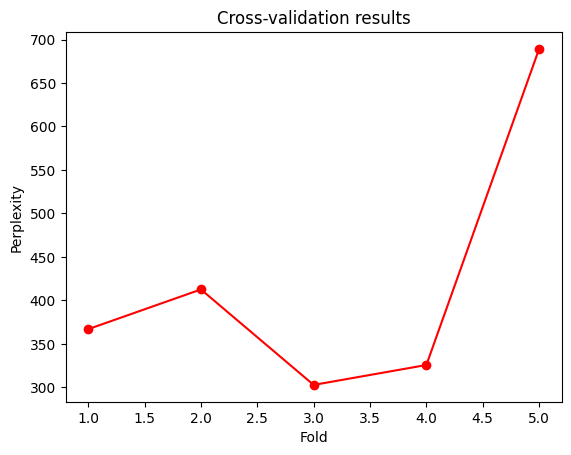

In [28]:
from sklearn.model_selection import KFold
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt
import numpy as np


# Load the data and preprocess it.
momentum = load_dataset('json', data_files='MPM.json')
flattened_mpm = momentum.flatten()
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def preprocess_function(examples):
    articles = [" ".join(article.split()) for article in examples["Article_Body"]]
    return tokenizer(articles, truncation=True)

tokenized_mpm = flattened_mpm.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=momentum["train"].column_names,
)

block_size = 60

def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

mpm_dataset = tokenized_mpm.map(group_texts, batched=True, num_proc=4)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Define the hyperparameters and training arguments.
training_args = TrainingArguments( 
    output_dir="gpt_model",
    overwrite_output_dir=True,
    learning_rate=8e-5, # decreased learning rate
    weight_decay=0.01,
    num_train_epochs=900,
    logging_steps=100000,
    save_total_limit=2,
    per_device_train_batch_size=16, # increased batch size
    gradient_accumulation_steps=4, # added gradient accumulation
    save_steps=10_000,
    evaluation_strategy='no'
)
# Define the k-fold cross-validation scheme.
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize an empty list to store the perplexity values.
perplexity_values = []

# Run the k-fold cross-validation.
for i, (train_index, eval_index) in enumerate(kf.split(mpm_dataset["train"])):
    print(f"\n\nFold {i+1} of {k}\n\n")
    
    train_dataset = mpm_dataset["train"].select(train_index)
    eval_dataset = mpm_dataset["train"].select(eval_index)
    
    # Load the model and initialize the trainer.
    mpm_model = AutoModelForCausalLM.from_pretrained("gpt2")
    trainer = Trainer(
        model=mpm_model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )
    
    # Train the model.
    trainer.train()
    
    # Evaluate the model on the validation set.
    eval_results = trainer.evaluate(eval_dataset)
    perplexity = np.exp(eval_results["eval_loss"])
    perplexity_values.append(perplexity)
    print(f"Perplexity: {perplexity}\n\n")
    
    # Save the model.
    mpm_model.save_pretrained(f"/scratch/kkonatha/model_validation")
    

# Plot the perplexity values for each fold.
plt.plot(range(1, k+1), perplexity_values, 'ro-')
plt.xlabel('Fold')
plt.ylabel('Perplexity')
plt.title('Cross-validation results')
plt.show()